_(tv) 2021-11-21, 2023-12-11, 2024-04-24_

# Generate Uniform Distribution on the Sphere

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import scipy

In [3]:
import itertools
def colorcycle():
    return itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [4]:
rng = np.random.default_rng()

In [5]:
N = 5000 # number of points to sample

In [6]:
def to_cartesian(r, phi, theta):
    ''' helper function to convert from spherical to cartesian coordinates '''
    x = r*np.cos(phi)*np.sin(theta)
    y = r*np.sin(phi)*np.sin(theta)
    z = r*np.cos(theta)
    return x,y,z

We first demonstrate the "problem": just representing points in spherical coordinates with the two angles (phi,theta) and drawing randomly the two angles from uniform distributions is _not_ the right thing to do.
Instead, one needs to account for the volume element of the spherical coordinates and draw accordingly for theta.

In [7]:
def uniform_angles(N):
    phi = rng.random(N)*2*np.pi
    theta = rng.random(N)*np.pi
    return to_cartesian(1,phi,theta)

In [8]:
def non_uniform_angles(N):
    phi = rng.random(N)*2*np.pi
    theta = 2*np.arcsin(np.sqrt(rng.random(N)))
    return to_cartesian(1,phi,theta)

In the plot one should be able to see that on the left (uniformly drawn angles), the points accumulate somewhat towards the North and South pole. To the right (correctly drawn angles) this effect should have gone away.

<IPython.core.display.Javascript object>


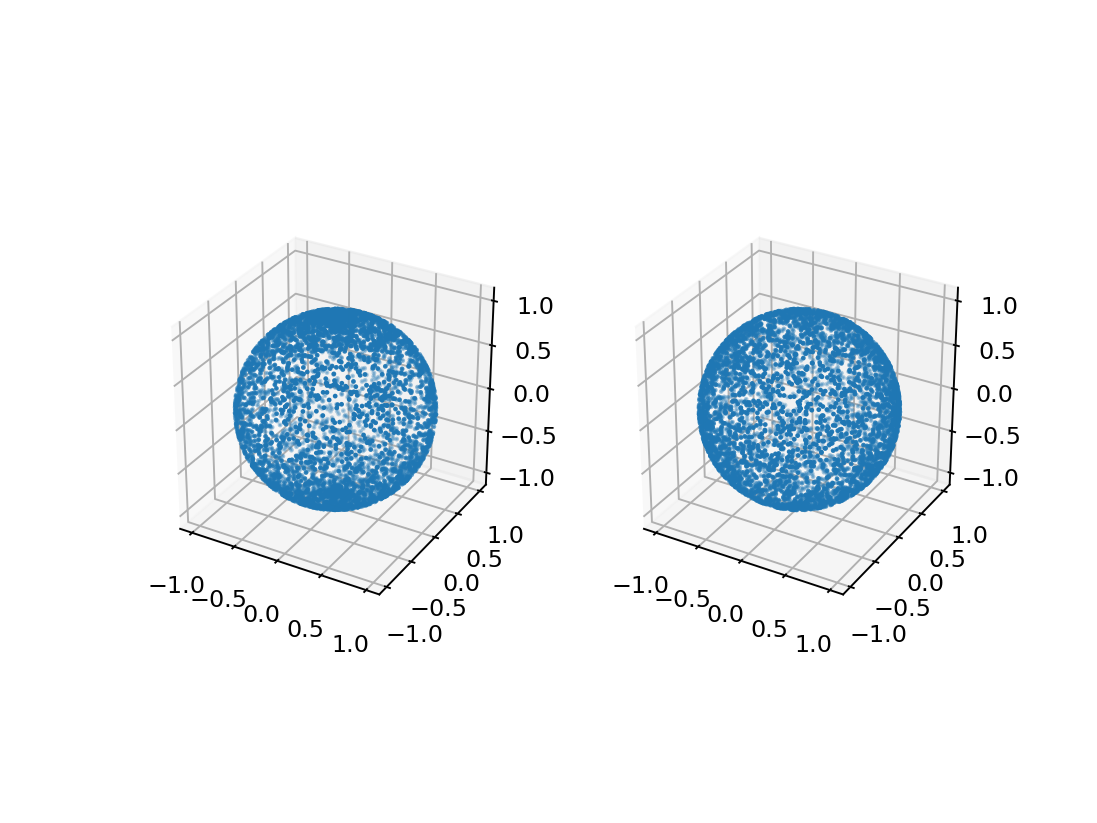

In [9]:
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d', box_aspect=(1,1,1))
x,y,z = uniform_angles(N)
ax.scatter(x,y,z,s=1)
ax = fig.add_subplot(122, projection='3d', box_aspect=(1,1,1))
x,y,z = non_uniform_angles(N)
ax.scatter(x,y,z,s=1)
plt.show()

Since evaluating the arcsin for every point is costly, a numerically equally acceptable method is to just draw three normal-distributed random numbers and normalize the resulting vectors. The resulting distribution is by construction homogeneous.
The advantage is that this method also works in higher dimensions.

In [10]:
def sph_gaussian(N,dim=3):
    v = rng.standard_normal((dim,N))
    v = v / (np.linalg.norm(v,axis=0))
    return *v, # unpack into d-tuple of arrays x,y,z,...

<IPython.core.display.Javascript object>


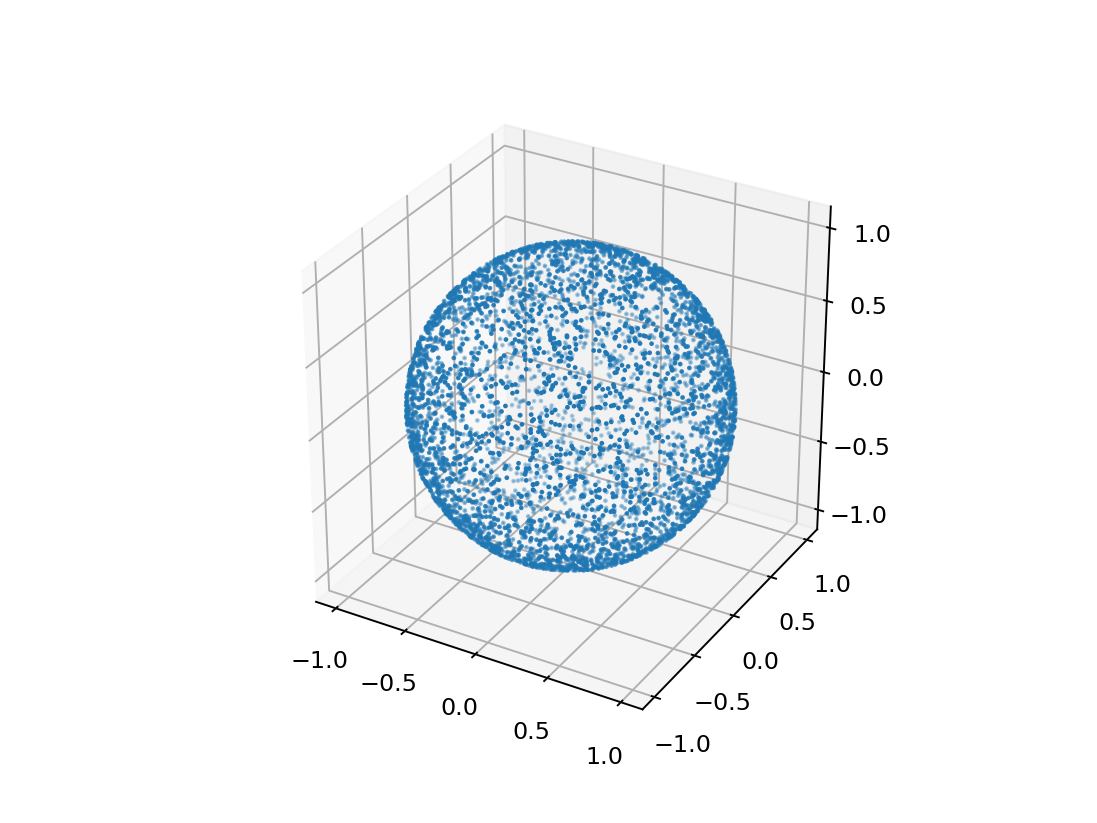

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
x,y,z = sph_gaussian(N)
ax.scatter(x,y,z,s=1)
plt.show()

Another method that does not even require to draw from a non-uniform distribution is just to draw uniformly distributed vectors in the cube enclosing the sphere, discard everything that is outside the sphere, and take the normalized remainders. The drawback is that this throws away quite a few points (in fact, since the volume of the cube is 8 and that of the sphere is 4pi/3, around 48% of all points... - recall how to calculate pi with Monte Carlo simulations?)
Also this method works in higher dimensions, but think about the acceptance rate...

In [12]:
def throwaway(N,dim=3):
    v = rng.random(size=(dim,N))*2-1
    vnorm = np.linalg.norm(v,axis=0)
    keep = vnorm<=1.0
    v = v[:,keep]
    kept = v.shape[-1]
    print ("{}/{} ({:.2f}%) points survived".format(kept,N,kept/N*100))
    if dim==3: print ("estimate of pi is thus {}".format(kept/N*6))
    #v = v / np.linalg.norm(v,axis=0)
    v = v / vnorm[keep]
    return *v,

<IPython.core.display.Javascript object>


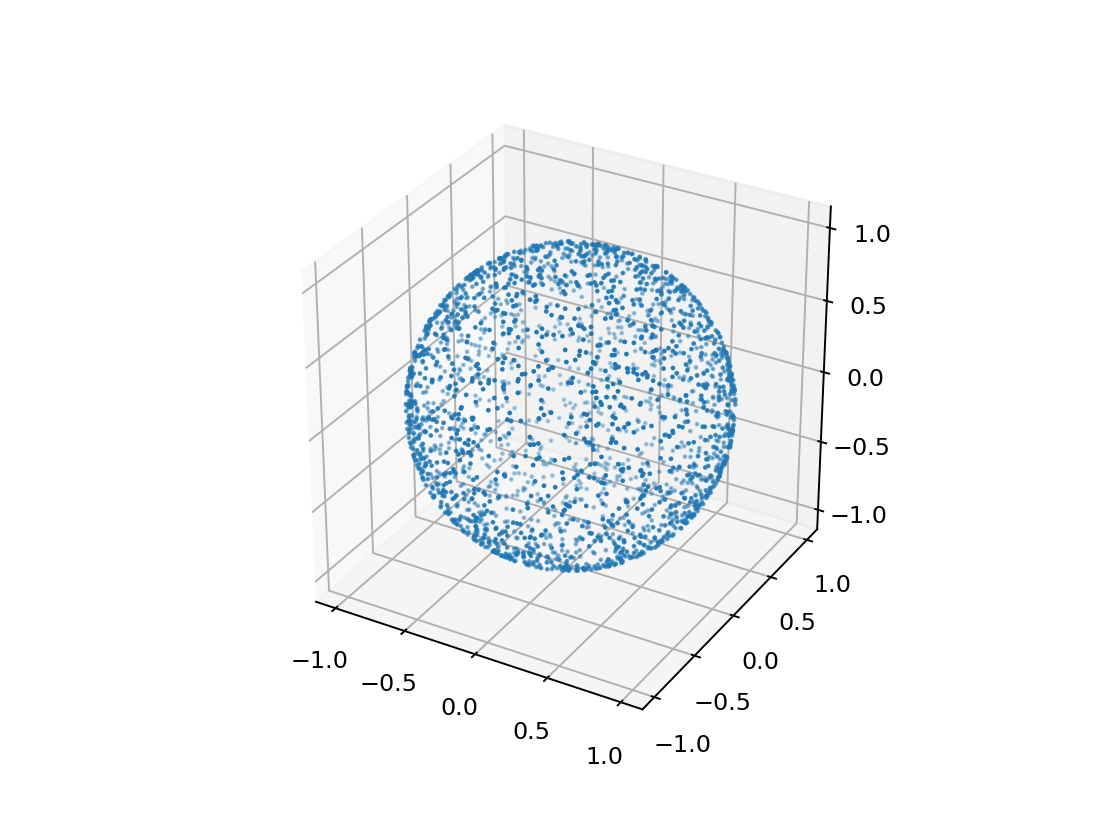

2528/5000 (50.56%) points survived
estimate of pi is thus 3.0336000000000003


In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', box_aspect=(1,1,1))
x,y,z = throwaway(N)
ax.scatter(x,y,z,s=1)
plt.show()

# The angles between random unit vectors in d dimensions

An interesting question is: if we take two random vectors on the unit sphere, how is their scalar product distributed? In other words, what is our expectation for the angle between two randomly drawn unit vectors?

Let's check the 3d case we have just plotted: the scalar product is uniformly distributed over [-1,1], thus the cosine of the angle between two vectors is uniformly distributed.

In [14]:
dot3d = x*x[0]+y*y[0]+z*z[0]

<IPython.core.display.Javascript object>


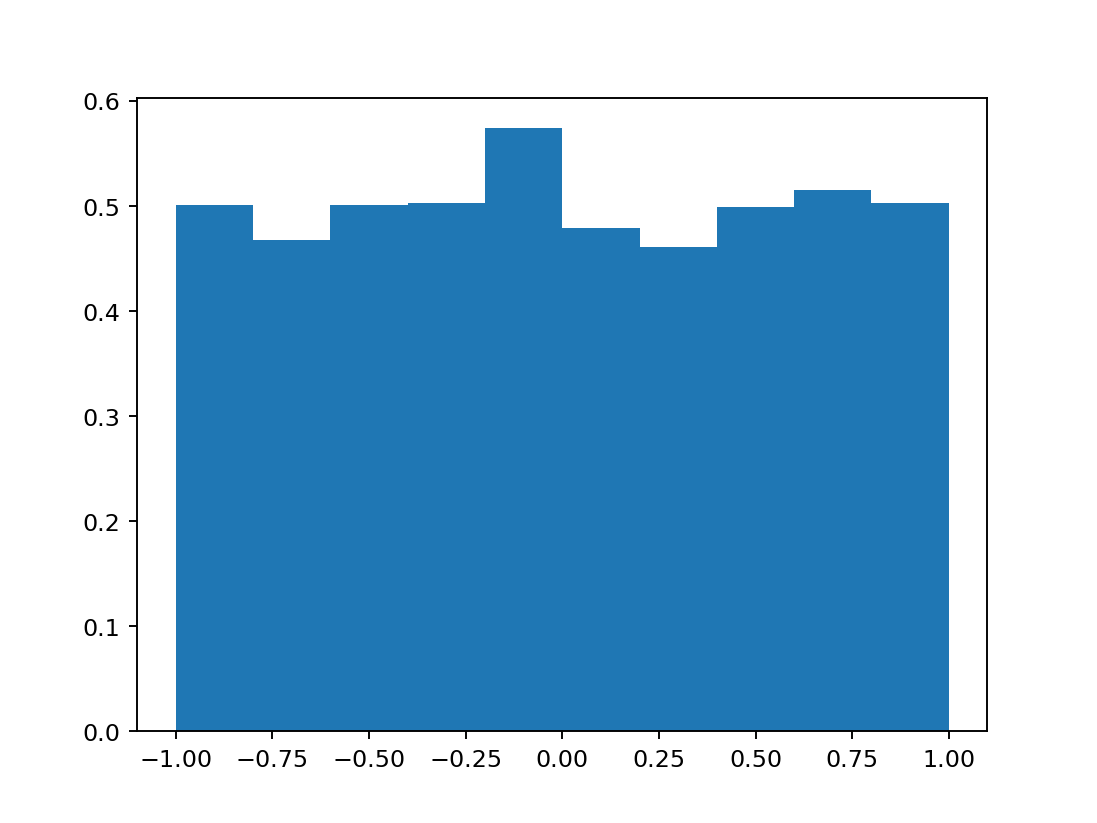

In [15]:
plt.figure()
plt.hist(dot3d[1:],range=(-1,1),density=True)
plt.show()

This question has an interesting answer in dimensions other than three. Intuitively, the 1d case must be singular, because only 1 and -1 are allowed for both the vectors and their scalar product. The 2d case indeed shows a signature of this singularity still: in 2d, -1 and 1 are by far the most likely outcomes. As the dimensionality increases beyond three, the most likely outcome changes to be zero, i.e., two random d-dimensional vectors become increasingly likely to be orthogonal to each other. The limiting case of infinite dimensions gives in fact a Gaussian, with variance 1/d.

We test this empirically and plot the histograms together with the known analytical result, which is a variant of the beta distribution (not proven here).

For a sketch of a proof why the distribution is given by the specific beta distribution
\\[ p_d(u)\propto u^{(d-1)/2-1}(1-u)^{(d-1)/2-1}\\]
where $u=(t+1)/2$ and $t$ is the scalar product $t=\vec x_1\cdot\vec x_2$, see [https://stats.stackexchange.com/questions/85916/distribution-of-scalar-products-of-two-random-unit-vectors-in-d-dimensions]

In [19]:
d_list = [2,3,4,6,10]
v = {}
pdf = {}
for dim in d_list:
    v[dim] = np.array(sph_gaussian(100000,dim=dim)).T[1:]
    pdf[dim] = scipy.stats.beta(a=(dim-1)/2,b=(dim-1)/2).pdf

<IPython.core.display.Javascript object>


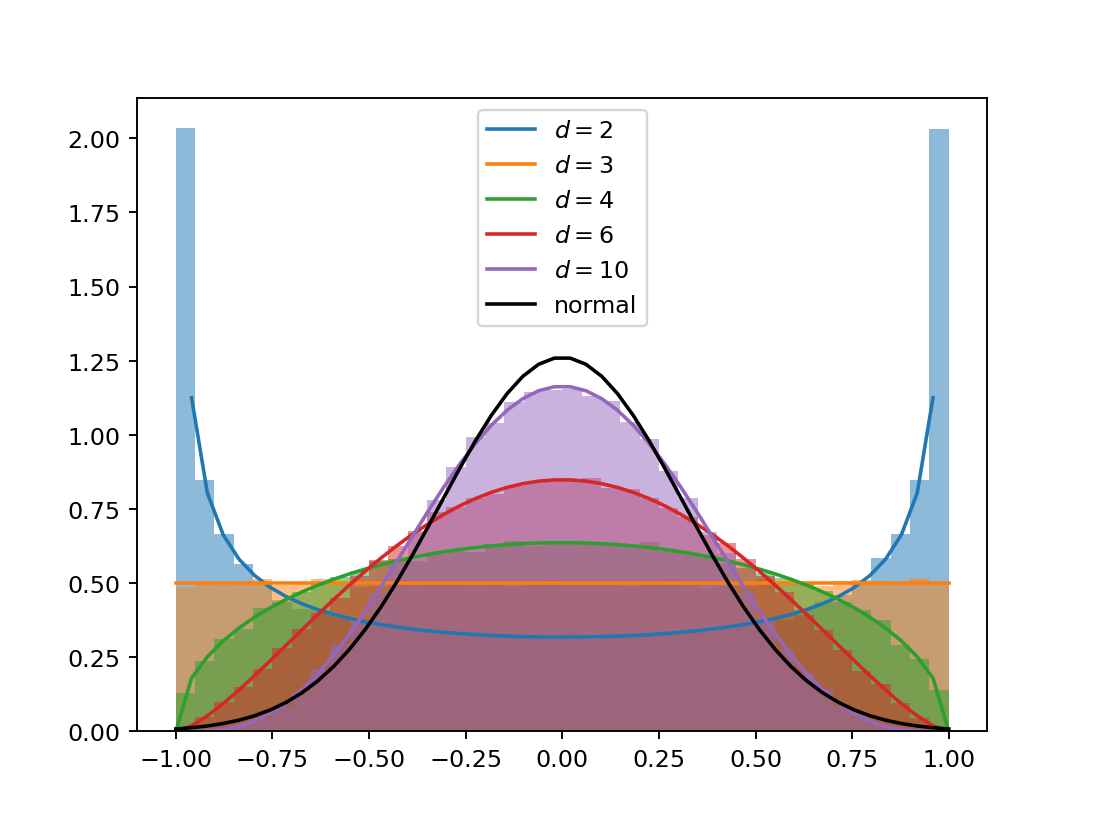

In [21]:
plt.figure()
colors = colorcycle()
x_ = np.linspace(-1,1,50)
for dim in d_list:
    c = next(colors)
    plt.hist(np.dot(v[dim],v[dim][0]),range=(-1,1),bins=40,density=True,alpha=0.5,fc=c)
    plt.plot(x_, pdf[dim]((x_+1)/2)/2,color=c,label=r'$d={}$'.format(dim))
plt.plot(x_,np.exp(-x_**2/.2)/np.sqrt(.2*np.pi),color='black',label='normal')
plt.legend()
plt.show()

Note how in particular the result for d=4 looks peculiar.
The Gaussian distribution that is approached in the limiting case of infinite dimensions has variance 1/d. Thus, in infinite dimensions, two randomly chosen normal vectors are orthogonal to each other almost certainly! This has implications in physics, for example when studying particle interactions in infinite dimension: two particles essentially never "see" each other.